In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import pymongo
import pyarrow as pa
import pyarrow.parquet as pq
from pymongoarrow.monkey import patch_all
patch_all()

from config import Config

client = pymongo.MongoClient(Config.MONGO_URI)
db = client[Config.MONGO_DB]

In [104]:
# aggregate + save
from loader import run
need_to_rebuild_parquets = False # set to True to rebuild parquet files from DB
if need_to_rebuild_parquets:
    run()

In [105]:
# load
phishing = pq.read_table('floor/phishing.parquet')
benign_u = pq.read_table('floor/benign.parquet')

from transformers.drop_nontrain import drop_nontrain
phishing = drop_nontrain(phishing)
benign_u = drop_nontrain(benign_u)

# realign schemas (parquet files save in nonsense orders)
phishing_order = phishing.schema.names
benign = benign_u.select(phishing_order)

data = pa.concat_tables([phishing, benign])
df = data.to_pandas()
from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)
df

import pandas as pd


pd.set_option('display.max_rows', 2000)

df


,label,tls_CA_certs_in_chain_ratio,tls_broken_chain,tls_chain_len,tls_cipher_id,tls_client_auth_crt_count,tls_common_name_count,tls_critical_extensions,tls_expired_chain,tls_has_tls,...,dns_TXT_count,dns_soa_primary_ns_subdomains,dns_soa_primary_ns_digit_count,dns_soa_primary_ns_len,dns_soa_admin_email_len,dns_soa_admin_email_subdomains,dns_soa_admin_email_digit_count,dns_domain_name_in_mx,dns_txt_google_verified,dns_txt_spf_exists
0,misp:phishing,0.500000,0.0,4.0,0.0,2.0,3.0,7.0,0.0,True,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
3,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,misp:phishing,0.333333,0.0,3.0,1.0,2.0,3.0,5.0,0.0,True,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295348,benign:unknown,0.500000,0.0,4.0,2.0,2.0,4.0,7.0,0.0,True,...,0,0.0,0.0,23.0,19.0,0.0,0.0,0,0,0
295349,benign:unknown,0.333333,0.0,3.0,2.0,2.0,3.0,5.0,0.0,True,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
295350,benign:unknown,0.333333,0.0,3.0,2.0,2.0,3.0,5.0,0.0,True,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
295351,benign:unknown,0.333333,0.0,3.0,0.0,2.0,3.0,5.0,0.0,True,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datetime

#le = LabelEncoder()
#labels = le.fit_transform(df['label'])

class_map = {"benign:unknown": 0, "misp:phishing": 1}
labels = df['label'].apply(lambda x: class_map[x])

features = df.drop('label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

start = datetime.datetime.now()

params = {
    "max_depth": 9,
    "eta": 0.15,
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "min_child_weight": 2.0,
    "subsample": 0.6,
    "sampling_method": "gradient_based",
    "alpha": 0,
    "gamma": 0.1,
    "lambda": 1.0,
    "max_delta_step": 0,
    "grow_policy": "lossguide",
    "max_bin": 512,
}
trees = 240

model = XGBClassifier(
  **params, n_estimators=trees
)
do_cross_val = True
if do_cross_val:
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
  results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

finish = datetime.datetime.now()
delta = finish - start
print(delta)

F1: 93.80% (0.10%)
0:00:26.285184


In [75]:
## Hyperparameter tuning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datetime

class_map = {"benign:unknown": 0, "misp:phishing": 1}


labels = df['label'].apply(lambda x: class_map[x])
features = df.drop('label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

params = {
    "eta": 0.15,
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    #"predictor": "gpu_predictor"
}
trees = 250

clf = XGBClassifier(**params)

grid = {
    "max_depth": [9],
    "min_child_weight": [2],
    "sampling_method": ["gradient_based"],
    "subsample": [0.6],
    "gamma": [0.1],
    "grow_policy": ["lossguide"],
    "max_bin": [512],
    "n_estimators": [240, 350, 500],
    "lambda": [1.0],
    "alpha": [0.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

grid_search = GridSearchCV(estimator=clf,
                           param_grid=grid,
                           #n_jobs=-1,
                           cv=cv,
                           scoring='neg_log_loss',#'f1',
                           verbose=3,
                           return_train_score=True)

grid_search.fit(X_train, y_train)

clf = grid_search.best_estimator_

scores = pd.DataFrame(grid_search.cv_results_)
col_names = ['mean_train_score', 'mean_test_score']

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END alpha=0.0, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=240, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.018, test=-0.042) total time=   5.0s
[CV 2/5] END alpha=0.0, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=240, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.018, test=-0.041) total time=   5.0s
[CV 3/5] END alpha=0.0, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=240, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.017, test=-0.043) total time=   5.1s
[CV 4/5] END alpha=0.0, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=240, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.017, test=-0.043) total time=   5.2s


[CV 1/5] END alpha=0.2, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=350, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.013, test=-0.043) total time=   6.4s
[CV 2/5] END alpha=0.2, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=350, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.013, test=-0.042) total time=   6.2s
[CV 3/5] END alpha=0.2, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=350, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.012, test=-0.042) total time=   6.4s
[CV 4/5] END alpha=0.2, gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_depth=9, min_child_weight=2, n_estimators=350, sampling_method=gradient_based, subsample=0.6;, score=(train=-0.012, test=-0.043) total time=   6.5s
[CV 5/5] END alpha=0.2, gamma=0.1, grow_policy=lossguide, la

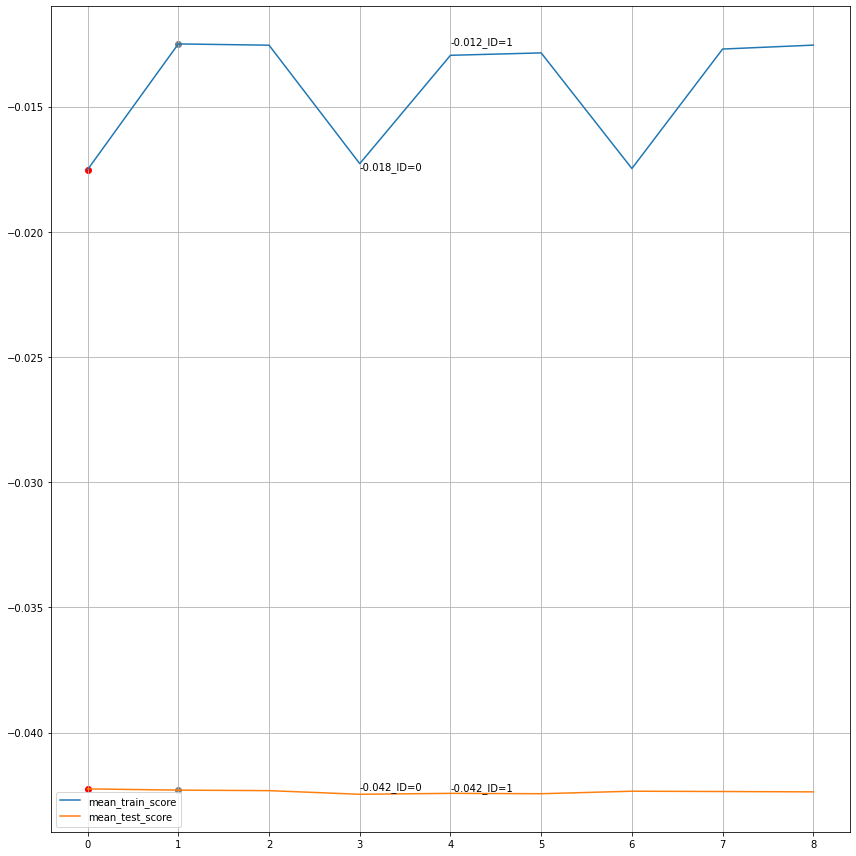

In [76]:
scores = pd.DataFrame(grid_search.cv_results_)

from numpy import array
from numpy.ma import masked_array
from numpy import *

col_names = ['mean_train_score', 'mean_test_score']
means_df = scores[col_names]
ax = means_df.plot(kind='line', grid=True)


from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 12]
plt.rcParams["figure.autolayout"] = True

#plt.rcParams["figure.dpi"] = 800

max_ids = means_df.idxmax(axis=0)

for i in range(len(max_ids)):
    for col_name in col_names:
        value = means_df[col_name][max_ids[i]]
        id = max_ids[i]
        
        color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'
        
        ax.scatter([id], [value],
                   marker='o',
                   color=color,
                   label='point',)

        ax.annotate(str(round(value, 3))+"_ID="+str(id),
                    (id, value),
                    xytext=(id+3, value))
        

In [78]:

scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,param_grow_policy,param_lambda,param_max_bin,param_max_depth,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.929439,0.072800,0.141141,0.001680,0.0,0.1,lossguide,1.0,512,9,...,-0.042246,0.000504,1,-0.017683,-0.018163,-0.017107,-0.017353,-0.017263,-0.017514,0.000375
1,6.007743,0.027397,0.159709,0.001084,0.0,0.1,lossguide,1.0,512,9,...,-0.042294,0.000692,2,-0.012302,-0.012937,-0.012505,-0.012432,-0.012300,-0.012495,0.000234
2,6.221261,0.071640,0.158387,0.002586,0.0,0.1,lossguide,1.0,512,9,...,-0.042316,0.000649,3,-0.012024,-0.013468,-0.012505,-0.012432,-0.012300,-0.012546,0.000489
3,5.009884,0.080009,0.142582,0.002099,0.15,0.1,lossguide,1.0,512,9,...,-0.042461,0.000460,9,-0.017374,-0.018504,-0.016827,-0.016795,-0.016885,-0.017277,0.000649
4,6.078915,0.138893,0.171445,0.017507,0.15,0.1,lossguide,1.0,512,9,...,-0.042424,0.000556,7,-0.012589,-0.013853,-0.011765,-0.013553,-0.012988,-0.012950,0.000737
5,6.558833,0.151570,0.167639,0.012345,0.15,0.1,lossguide,1.0,512,9,...,-0.042439,0.000566,8,-0.012589,-0.013853,-0.011299,-0.013553,-0.012977,-0.012854,0.000893
6,5.157125,0.064693,0.148090,0.006924,0.2,0.1,lossguide,1.0,512,9,...,-0.042338,0.000333,4,-0.017901,-0.017223,-0.017473,-0.017153,-0.017606,-0.017471,0.000271
7,6.175581,0.149670,0.161722,0.006650,0.2,0.1,lossguide,1.0,512,9,...,-0.042350,0.000548,5,-0.012855,-0.013114,-0.012263,-0.011791,-0.013477,-0.012700,0.000603
8,6.407954,0.160292,0.163817,0.002167,0.2,0.1,lossguide,1.0,512,9,...,-0.042365,0.000586,6,-0.012855,-0.012503,-0.012263,-0.011618,-0.013477,-0.012543,0.000617


In [107]:
_ = model.fit(X_train, y_train)

In [108]:
predicted = model.predict(X_test)

In [109]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

0.9421373200442967


In [28]:
# get gain score
score = model.get_booster().get_score(importance_type='gain')
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
sorted_score

[('has_tls', 122.59606170654297),
 ('joint-iso-itu_policy_count', 98.2258529663086),
 ('broken_chain', 65.35491180419922),
 ('dns_SOA_count', 60.26219940185547),
 ('dns_TXT_count', 48.61553192138672),
 ('lex_www_flag', 48.0981559753418),
 ('domain_lifetime', 47.015716552734375),
 ('lex_phishing_keyword_count', 43.551631927490234),
 ('root_cert_validity_remaining', 38.23231887817383),
 ('lex_digit_count', 33.647972106933594),
 ('lex_sub_count', 31.579769134521484),
 ('CA_certs_in_chain_ratio', 28.975114822387695),
 ('root_cert_validity_len', 27.736650466918945),
 ('tls_cipher_score', 26.709396362304688),
 ('dns_CNAME_count', 26.403310775756836),
 ('dns_A_count', 25.54125213623047),
 ('dns_NS_count', 22.961936950683594),
 ('domain_name_in_mx', 22.29218101501465),
 ('lex_subdomain_len', 19.874103546142578),
 ('client_auth_certs', 19.19256019592285),
 ('leaf_cert_validity_len', 17.810302734375),
 ('tls_version_score', 17.411319732666016),
 ('domain_registration_period', 17.223304748535156)

In [110]:
_ = model.fit(X_train, y_train)

In [111]:
predicted = model.predict(X_test)

In [112]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

0.9421373200442967


In [114]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predicted, labels=[1,0]))
print(" ")
print(classification_report(y_test, predicted, digits=4))


[[10209   889]
 [  365 77143]]
 
              precision    recall  f1-score   support

           0     0.9886    0.9953    0.9919     77508
           1     0.9655    0.9199    0.9421     11098

    accuracy                         0.9858     88606
   macro avg     0.9770    0.9576    0.9670     88606
weighted avg     0.9857    0.9858    0.9857     88606



In [19]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
    
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    #false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test['label'].values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [96]:
import hashlib
s = "ahoj"
int(hashlib.md5(s.encode("ascii")).hexdigest(), 16) % 2147483647


375790338